In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import numpy.matlib
import pickle
import random

from matplotlib import pyplot as plt
from scipy import linalg, sparse, stats
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize, scale
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity

Initialize an English dictionary to filter words from the GloVe dataset. The GloVe dataset used has parsed over Wikipedia and thus contains a lot of noise. This is filtered using a spell check

In [2]:
import hunspell
spellchecker = hunspell.HunSpell('../data/hunspell/en_US.dic',
                                 '../data/hunspell/en_US.aff')

In [3]:
GLOVE_PATH = '/mnt/guanabana/raid/data/datasets/GloVe/pretrained/glove.6B.300d.txt'
CAVS_PATH = '../data/filtered_broden_cavs.pickle'
EMBEDDING_PATH = '../data/word_embedding_6B_300D.pickle'
TEXTURE_PATH = "/raid/data/datasets/broden1_384/c_texture.csv"

In [4]:
textures = pd.read_csv(TEXTURE_PATH, index_col = 0)
texture_list = list(textures['name'])

Read the concept activation vectors from the Broden dataset as a dictionary

In [5]:
with open(CAVS_PATH, 'rb') as handle:
        cavs_broden = pickle.load(handle)

### Import GloVe

Extract the word embeddings from the GloVe dataset. The word embeddings are stored in a dictionary, with the word as key and vector as value, and in a matrix (n_samples x n_features). The original dataset contains about 400K words. All the words are run through a spell checker, if the word is not present in the English dictionary which was used, the word is removed. In total about 280000 words are removed from the GloVe dataset

In [6]:
if os.path.exists(EMBEDDING_PATH):
    with open(EMBEDDING_PATH, 'rb') as handle:
        embedding_dict = pickle.load(handle)

    glove_embedding_matrix = np.load('../data/glove_embedding_matrix.npy')
    glove_words = list(embedding_dict.keys())
    
else:
    embedding_dict = {}
    glove_words = []
    glove_embedding_matrix = np.zeros((400000, 300))

    # parse through the GloVe data
    with open(GLOVE_PATH, 'r', encoding="utf-8") as f:
        for i, line in tqdm(enumerate(f)):
            
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32').reshape(1,-1)
            
            # apply a spell check
            try:
                if spellchecker.spell(word):
                    embedding_dict[word] = vector
                    glove_embedding_matrix[i] = vector
                    glove_words.append(word)
            except:
                UnicodeEncodeError
                    
    with open(EMBEDDING_PATH, 'wb') as handle:
        pickle.dump(embedding_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # not all 400K rows are used as a certain amount of words was removed by the spellchecker, 
    # thus the unused rows are removed from the matrix
    glove_embedding_matrix = glove_embedding_matrix[:len(glove_words)]
    np.save('../data/glove_embedding_matrix.npy', glove_embedding_matrix)

In [7]:
print('The amount of words left in the GloVe dataset:', glove_embedding_matrix.shape[0])

The amount of words left in the GloVe dataset: 118327


### Preprocess CAVs

Select the concepts from the Broden dataset, which are also available as word embedding. Several concepts in the Broden dataset end with _'-s'_. This is removed to get more concepts linked with an embedding. 

In [8]:
# list all Broden concepts
all_broden_concepts = list(cavs_broden.keys())

# remove duplicates from concept list (e.g. mountain-s is stored when mountain and mountain-s are both in the dataset)
# and remove the textures from the concepts
no_dups_concepts = [c for c in all_broden_concepts if c +'-s' not in all_broden_concepts and c not in texture_list]

In [9]:
print('Amount of CAVs left:', len(no_dups_concepts))

Amount of CAVs left: 649


In [10]:
# create a matrix of all cavs
cav_matrix = np.zeros((len(no_dups_concepts), cavs_broden[no_dups_concepts[0]]['cav'].shape[1]))
for i in range(len(no_dups_concepts)):
    cav = cavs_broden[no_dups_concepts[i]]['cav']
    cav_matrix[i] = cav

# remove the '-s' from the concepts if present 
broden_concepts = [c[:-2] if c[-2:] == '-s' else c for c in no_dups_concepts]

In [11]:
cav_matrix.shape

(649, 2048)

Extract concepts which have a CAV and a correspondence in the GloVe data. The index is stored to remove the unavailable concepts from the CAV matrix

In [12]:
# store the indices and the concepts with a correspondence in both datasets
embedding_idxs = [ix for ix, c in enumerate(broden_concepts) if c in embedding_dict.keys()]
embedding_concepts = [c for ix, c in enumerate(broden_concepts) if c in embedding_dict.keys()]

In [13]:
print("The amount of CAVs with a corresponding word embedding: ", len(embedding_idxs))

The amount of CAVs with a corresponding word embedding:  363


In [14]:
#extract the selected CAVs
cavs_with_embedding = cav_matrix[embedding_idxs]

In [15]:
cavs_with_embedding.shape

(363, 2048)

Create matrix with CAVs which do not have a matching word embedding

In [16]:
cav_no_glove = np.delete(cav_matrix, embedding_idxs, axis=0)
cav_no_glove_concepts = [conc for conc in broden_concepts if conc not in embedding_concepts]

Normalize the CAV matrices to norm-1

In [17]:
cavs_norm = normalize(cavs_with_embedding,axis=1)
cav_no_glove_norm = normalize(cav_no_glove, axis=1)

Add the matrices back together, the first 363 samples have a correspondence in the GloVe dataset, while the other part is used to better capture the structure of the CAV manifold

In [18]:
cavs_sorted = np.concatenate((cavs_norm, cav_no_glove_norm))
cavs_sorted_concept = embedding_concepts + cav_no_glove_concepts

### Include SoN image in the Manifold Alignment

In [19]:
# Read SoN info, where the ID equals the image name in the folder structure
son_info = pd.read_csv('../data/son_votes.csv', index_col = 0)

with open('../data/son_tensors.pickle', 'rb') as handle:
        son_tensors = pickle.load(handle)

From each score range (0-1, 1-2, ..., 9-10) 100 images are randomly sampled

In [20]:
son_manifold_imgs = []
for i in range(10):
    son_subset_idxs = list(son_info.query('Average > %s & Average <= %s' % (str(i), str(i+1))).index)
    son_random_idxs = random.sample(son_subset_idxs, 100)
    son_manifold_imgs.extend(son_random_idxs)

Create a matrix of the tensors of the random selected images

In [21]:
son_manifold_matrix = np.zeros((len(son_manifold_imgs), 2048))
for a, ix in enumerate(son_manifold_imgs):
    img_name_in_df = str(son_info.loc[ix, 'ID'])
    if ix >= 52642:
        ix += 1
    if ix >= 201047:
        ix += 1
    img_name_in_dict = son_tensors[str(ix)][0]
    
    if img_name_in_df != img_name_in_dict:
        print(a)
        
    else:
        img_tensor = son_tensors[str(ix)][2].numpy()
        son_manifold_matrix[a] = img_tensor
    

Normalize the data

In [22]:
son_manifold_matrix = normalize(son_manifold_matrix, axis=1)

### Add SoN to CAVs

In [23]:
cavs_sorted_son = np.concatenate((cavs_sorted, son_manifold_matrix))

In [24]:
cavs_sorted_son.shape

(1649, 2048)

### Preprocess GloVe

Create a matrix of the word embeddings for the concepts which also have a CAV.

In [25]:
embeddings_with_cav = np.zeros((len(embedding_idxs), 300))
for i in range(len(embedding_concepts)):
    word_vec = embedding_dict[embedding_concepts[i]].reshape(1,-1)
    embeddings_with_cav[i] = word_vec

In [26]:
embeddings_with_cav.shape

(363, 300)

Create matrix with GloVe embeddings which do not have a matching CAV

In [27]:
#Initiate a matrix with the required shape
glove_no_cav = np.zeros((len(glove_words) - len(embedding_concepts), 300))

# Also store the GloVe concept names (which do not have a match in CAV)
glove_no_cav_concept = []

idx = 0
for concpt in embedding_dict.keys():
    if concpt not in embedding_concepts:
        glove_no_cav_concept.append(concpt)
        concpt_vec = embedding_dict[concpt]
        glove_no_cav[idx] = concpt_vec
        idx +=1

In [28]:
glove_no_cav.shape

(117964, 300)

Normalize all data to norm-1

In [29]:
glove_norm = normalize(embeddings_with_cav,axis=1)
glove_no_cav_norm = normalize(glove_no_cav, axis=1)

Find the nearest neighbors of the GloVe embeddings which do have correspondence with CAVs. These are used in the manifold alignment to preserve the structure of the GloVe data

Create a list of unique indices of the nearest neigbors to the GloVe embeddings which have a correspondence with a CAV

In [322]:
# takes about 3min to run
glove_neighbors = []
for k in tqdm(range(embeddings_with_cav.shape[0])):
    glove_cosim = cosine_similarity(glove_no_cav_norm, glove_norm[k].reshape(1,-1))
    glove_cosim_ixs = glove_cosim.argsort(axis=0)[::-1][:10]
    print(embedding_concepts[k])
    print('--------')
    for ixs in glove_cosim_ixs:
        print(glove_no_cav_concept[ixs.item()])
        if ixs.item() not in glove_neighbors:
            glove_neighbors.append(ixs.item())
    print('\n')

sky
--------
skies
bright
blue
horizon
darkness
dark
sun
lights
heavens
starry


tree
--------
trees
pine
oak
shrubs
planted
trunks
bark
garden
eucalyptus
shrub


building
--------
buildings
built
construction
houses
constructed
structure
build
brick
demolished
structures


person
--------
someone
man
anyone
woman
one
actually
persons
people
else
somebody


head
--------
heads
assistant
chief
headed
director
deputy
chair
hand
then
former


leg
--------
legs
thigh
knee
ankle
injury
shoulder
wrist
groin
foot
elbow


torso
--------
buttocks
torsos
thighs
legs
abdomen
limbs
pelvis
hips
forearm
extremities


table
--------
tables
sit
sitting
room
dining
chairs
dinner
side
sat
place


arm
--------
shoulder
wrist
hand
forearm
arms
right
elbow
hands
finger
chest


road
--------
roads
route
lane
along
intersection
roadway
junction
highways
trail
lanes


ear
--------
ears
eye
nose
throat
mouth
jaw
eyes
eardrum
tongue
teeth


grass
--------
grasses
lawns
roots
weeds
dirt
turf
trees
shrubs
grassy


horse
--------
horses
thoroughbred
riding
breeders
racing
rode
derby
jockey
ride
stallion


motorbike
--------
motorcycle
motorbikes
motorcycles
moped
taxi
minibus
rickshaw
motorcyclists
bike
parked


train
--------
trains
rail
commuter
freight
passenger
buses
subway
passengers
station
carriages


bathtub
--------
tub
faucet
jacuzzi
latrine
bathtubs
tubs
bucket
drowned
drown
soapy


toilet
--------
toilets
restroom
lavatory
tub
restrooms
bathrooms
laundry
flush
urinals
flushed


refrigerator
--------
fridge
freezer
refrigerated
refrigerators
dishwasher
drawer
drawers
conditioner
tub
airtight


laminate
--------
flooring
laminated
laminates
linoleum
paneling
plywood
veneer
fiberglass
veneers
hardwood


counter
--------
anti
against
countering
threat
strategy
terrorism
threats
measures
response
tactics


wardrobe
--------
costume
clothes
stylist
dress
hairstyle
outfits
attire
malfunction
wardrobes
clothing


computer
--------
computers
software
technology
computing
systems
hardware
elect

machine
--------
machines
automatic
gun
guns
automated
hand
equipment
using
machinery
heavy


staircase
--------
staircases
stairways
stairwell
foyer
walkway
stair
doorway
balustrade
courtyard
marble


castle
--------
manor
castles
fortress
medieval
built
château
town
situated
rebuilt
residence


patty
--------
heiress
loveless
seeded
peppermint
seed
7-5
unseeded
davenport
6-3
6-2


altar
--------
altars
basilica
cathedral
sacristy
pews
apse
crucifix
sacrificial
statue
nave


pasture
--------
pastures
grazing
arable
graze
farmland
meadow
grassland
grasslands
grasses
cows


trouser
--------
trousers
pants
pant
pantsuits
pleated
pinstriped
pinstripe
pantsuit
blouse
sleeves


billboard
--------
chart
charts
peaked
debuted
peaking
number-one
albums
charted
charting
airplay


nursery
--------
nurseries
kindergarten
rhyme
preschool
garden
kindergartens
rhymes
gardens
daycare
elementary


decoration
--------
decorations
decorated
decorative
ornamentation
ornament
sculptural
ornaments
stucco
o

altarpiece
--------
altarpieces
frescoes
triptych
fresco
annunciation
sacristy
baroque
apse
15th-century
bas-relief


windscreen
--------
windshield
wipers
windshields
headlight
wiper
headlights
fairing
wrap-around
undercarriage
radiator


wheelchair
--------
wheelchairs
crutches
handicapped
paraplegic
disabled
quadriplegic
wheeled
motorized
athlete
bike


planter
--------
planters
landowner
well-to-do
plantation
aristocracy
aristocrat
grower
sharecropper
newspaperman
slaveholder


driveway
--------
driveways
parked
dirt
walkway
gravel
garage
courtyard
porch
sidewalks
parking


fairway
--------
par-4
par-5
fairways
3-wood
tee
par-3
bunker
putt
5-iron
putted


courthouse
--------
courthouses
outside
county
courtrooms
jail
capitol
arraignment
midtown
buildings
sheriff


yard
--------
yards
foot
touchdown
corner
fenced
meter
shipyard
20-meter
hauled
garage


carousel
--------
carousels
carriage
menagerie
rides
merry-go-round
fairground
amusement
trolley
trolleys
coaster


slide
--------
s

stalls
--------
stall
vendors
hawkers
kiosks
booths
shacks
eateries
aisles
souvenir
shop


niche
--------
niches
profitable
specialty
marketplace
lucrative
advertisers
specialized
cater
carve
thriving


lawn
--------
lawns
mower
croquet
garden
mowing
mowers
manicured
mow
backyard
grassy


chalet
--------
chalets
bungalow
lakeside
palatial
bungalows
rustic
farmhouse
alpine
cottages
luxurious


guardhouse
--------
five-story
storehouses
blockhouse
stockade
10-story
ramparts
two-storied
manse
26-story
colonnaded


hut
--------
huts
thatched
pizza
shack
taco
roofed
quonset
lodge
cottages
sunglass


lagoon
--------
lagoons
beaches
shoreline
brackish
pond
saltwater
inlets
coastline
inlet
ponds


shed
--------
shedding
sheds
fell
gained
closed
tumbled
slid
hang
slipped
composite


downtown
--------
midtown
city
streets
neighborhood
waterfront
mall
avenue
outside
suburb
boulevard


catwalk
--------
catwalks
couture
strutting
strutted
menswear
fashion
strut
paraded
showroom
ready-to-wear


bog


In [194]:
print('The number of unique neighours found:', len(glove_neighbors))

The number of unique neighours found: 2646


Extract the nearest neighbours from the data

In [196]:
glove_no_cav_nneigh = glove_no_cav_norm[glove_neighbors]
glove_no_cav_concept_nneigh = [glove_no_cav_concept[neigh] for neigh in glove_neighbors]

Concatenate the GloVe data together, the first 363 rows have correspondence in the CAV dataset. The other data is used the preserve the structure of the GloVe manifold during the alignment

In [197]:
glove_sorted = np.concatenate((glove_norm, glove_no_cav_nneigh))
glove_sorted_concept = embedding_concepts.copy()
glove_sorted_concept.extend(glove_no_cav_concept_nneigh)

In [198]:
len(glove_sorted_concept)

3009

---

In [199]:
print('Amount of CAVs used:', cavs_sorted_son.shape[0])
print('Amount of GloVes used:', glove_sorted.shape[0])

Amount of CAVs used: 1649
Amount of GloVes used: 3009


## Manifold alignment

Function to solve the generalized eigenvalue decomposition, which is a copy of the MatLab implementation of Devis Tuia

In [250]:
def gen_eig(A, B, option, n_eig, rankA, rankB):
    """
    Extracts generalized eigenvalues for problem A * U = B * U * landa
    """
    
    
    n_eig = min(n_eig, rankA, rankB)
    
    B = (B + B.T) / 2
    R = B.shape[0]
    rango = rankB
    
    if rango == R:
        U = np.zeros((R, n_eig))
        D = np.zerose((n_eig, n_eig))
        inv_B = np.linalg.inv(B)
        for k in tqdm(range(n_eig)):
            d, a = sparse.linalg.eigs(np.matmul(inv_B, A),1, which=option) #'a' are the eigenvectors in the matlab code
            d = d.real
            a = a.real
            
            ab = np.matmul(a.T, B)
            a = np.divide(a, np.sqrt(np.matmul(ab, a)))
            U[:,k] = a
            D[k,k] = d
            
            ba = np.matmul(B, a)
            aTb = np.matmul(a.T, B)
            dba = np.matmul(d, ba)
            A = A - np.matmul(dba, aTb)
        
        return U, D, n_eig
    
    else:
        print('Calculating d and v')
        d, v = sparse.linalg.eigs(B, rango)
        d = d.real
        v = v.real
        
        B = np.matmul(v.T, B)
        B = np.matmul(B, v)
        
        A = np.matmul(v.T, A)
        A = np.matmul(A, v)
        
        U2 = np.zeros((rango, n_eig))
        D = np.zeros((n_eig, n_eig))
        print('Calculation inverse of B')
        inv_B = np.linalg.inv(B)
        
        for k in tqdm(range(n_eig)):
            
            d, a = sparse.linalg.eigs(np.matmul(inv_B, A),1, which=option)
            d = d.real
            a = a.real
            
            ab = np.matmul(a.T, B)
            aba = np.matmul(ab, a)
            a = np.divide(a, np.sqrt(aba))
            
            U2[:,k] = a.flatten()
        
            D[k,k] = d
            
            ba = np.matmul(B, a)
            aTb = np.matmul(a.T, B)
            
            dba = d * ba
            A = A - np.matmul(dba, aTb)
        
        U = np.matmul(v, U2)
        return U, D, n_eig

Transpose the data to column matrices

In [225]:
cavs_sorted_t = cavs_sorted_son.T
glove_sorted_t = glove_sorted.T

d1, n1 = cavs_sorted_t.shape
d2, n2 = glove_sorted_t.shape

In [226]:
tot_samples = n1+n2
tot_samples

4658

As the data is normalized to norm 1, the multiplication of the matrix with its transpose should show 1s along the diagonal

In [227]:
# plt.imshow(np.matmul(cavs_sorted_t.T, cavs_sorted_t))

To perform manifold allignment the MatLab code from Devis Tuia is followed: https://github.com/dtuia/KEMA/blob/master/general_routine/KMA.m

In [323]:
n_samples = len(embedding_concepts)
MU = 0.95
LAMBDA = 0.5

Compute the adjacency matrices for both the CAV and GloVe data

In [324]:
n_neighbors = 10
cav_knn_graph = kneighbors_graph(cavs_sorted_son, n_neighbors, mode = 'connectivity')
cav_knn_graph = cav_knn_graph.toarray()

In [325]:
glove_knn_graph = kneighbors_graph(glove_sorted, n_neighbors, mode = 'connectivity', n_jobs = 10)
glove_knn_graph = glove_knn_graph.toarray()

In [326]:
W = linalg.block_diag(cav_knn_graph, glove_knn_graph)

In [327]:
# plt.imshow(W)

Similarity matrix (Ws) encodes the samples belonging to the same class. In this research, there is a pairwise connections, every CAV only has a single match with a word embedding. This relation can be captured by the identity matrix. <br> The corresponding diagonal row sum matrix (Ds) results from summing Ws along the rows and converting the sums to a diagonal matrix.

In [328]:
Ws = np.zeros((n1+n2, n1+n2))

Ws1 = np.eye(n1)
Ws2 = np.eye(n2)
Ws3 = np.eye(n_samples)

Ws[:n1, :n1] = Ws1
Ws[n1:, n1:] = Ws2
Ws[n1:(n1+n_samples), :n_samples] = Ws3
Ws[:n_samples, n1:(n1+n_samples)] = Ws3

Ws = Ws + np.eye(Ws.shape[0])

# the identity matrices of Ws3 are not plotted on the imshow, but when plotting the right coordinates it does appear
#plt.imshow(Ws)
#plt.imshow(Ws[:400, n1:n1+400])

# should be True
Ws[0, n1] == 1

True

The dissimilarity matrix (Wd) encodes which samples do not belong to the same class. This is important to capture, otherwise every sample will end in the same location (the origin) as this will capture the similarity between the samples. In this research it is assumed that every sample is dissimilar from every other sample except from itself.

In [329]:
Wd = np.ones((n1+n2, n1+n2))
np.fill_diagonal(Wd, 0)

Wd1 = np.ones((n_samples, n_samples))
np.fill_diagonal(Wd1, 0)

Wd[:n_samples, n1:(n1+n_samples)] = Wd1
Wd[n1:(n1+n_samples), :n_samples] = Wd1

Wd = Wd + np.eye(Wd.shape[0])

#plt.imshow(Wd[:400, n1:n1+400])
#plt.imshow(Wd)

Wd[n1:n1+5, :5]

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

Normalize the data

In [330]:
Sws = sum(sum(Ws))
Swd = sum(sum(Wd))
Sw = sum(sum(W))

Ws = Ws / Sws * Sw
Wd = Wd / Swd * Sw

Extract the diagionals from the matrices

In [331]:
Dd = np.diag(np.sum(Wd, axis=1))
Ds = np.diag(np.sum(Ws, axis = 1))
D = np.diag(np.sum(W, axis=1))

In [332]:
D.shape

(4658, 4658)

Create the Laplacians which represent the structure of the data

In [333]:
Ls = Ds - Ws # graph Laplacian of similarity 
Ld = Dd - Wd # Laplacian of dissimilarity

L = D - W # Laplacian topology/geometry

In [334]:
A = ((1 - MU) * L + MU * Ls) + LAMBDA * np.eye(Ls.shape[0])
B = Ld

In [335]:
L.shape

(4658, 4658)

In [336]:
A.shape

(4658, 4658)

In [337]:
kernel_cav = np.matmul(cavs_sorted_t.T, cavs_sorted_t)
# #the kernel should have a diagonal of 1s
#plt.imshow(kernel_cav)

In [338]:
kernel_glove = np.matmul(glove_sorted_t.T, glove_sorted_t)
#plt.imshow(kernel_glove)

In [339]:
K = linalg.block_diag(kernel_cav, kernel_glove)

In [340]:
# plt.imshow(K)

In [341]:
KA = np.matmul(K,A)
KB = np.matmul(K,B)

KAK = np.matmul(KA, K)
KBK = np.matmul(KB, K)

In [342]:
# plt.imshow(KBK)

Solve the generalized eigenvalue decomposition

In [343]:
rank_A = np.linalg.matrix_rank(KAK)
rank_B = np.linalg.matrix_rank(KBK)

In [344]:
ALPHA, LAMBDA,n_eig = gen_eig(KAK, KBK, 'LM', 8, rank_A, rank_B)

Calculating d and v
Calculation inverse of B


Sort the eigenvalues and vectors

In [345]:
lambda_idxs = np.diag(LAMBDA).argsort()
LAMBDA = np.sort(np.diag(LAMBDA))
LAMBDA = LAMBDA.reshape(LAMBDA.shape[0],1)

In [346]:
LAMBDA

array([[0.68075542],
       [0.68217297],
       [0.68561345],
       [0.68786909],
       [0.69004512],
       [0.69407906],
       [0.69988144],
       [1.4010313 ]])

In [347]:
ALPHA = ALPHA[:, lambda_idxs]

Divide the eigenvectors over the 2 datasets

In [348]:
E1 = ALPHA[:n1, :] #eigenvectors for the first dataset (CAV)
E2 = ALPHA[n1:, :] #eigenvectors for the second dataset (GloVe)

Rotate axis is necessary

In [349]:
sourceXpInv = (-1 * np.matmul(E1.T, kernel_cav)).T
sourceXp = np.matmul(E1.T, kernel_cav).T
targetXp = np.matmul(E2.T, kernel_glove).T

In [350]:
sourceXpInv = stats.zscore(sourceXpInv)
sourceXp = stats.zscore(sourceXp)
targetXp = stats.zscore(targetXp)

In [351]:
sourceXpInv.shape

(1649, 8)

In [352]:
ErrRec = np.zeros((n1, ALPHA.shape[1]))
ErrRecInv = np.zeros((n1, ALPHA.shape[1]))

In [353]:
m1 = np.zeros((n1, ALPHA.shape[1]))
m1inv = np.zeros((n1, ALPHA.shape[1]))
m2 = np.zeros((n1, ALPHA.shape[1]))

In [354]:
cls = np.arange(n1).reshape(-1,1)

Compare the error of the inverted eigenvectors and the normal eigenvectors

In [355]:
for j in range(ALPHA.shape[1]):
    for i in range(n1):
        m1inv[i,j] = np.mean(sourceXpInv[i, j])
        #print('m1inv: ', m1inv)
        m1[i,j] = np.mean(sourceXp[i, j])
        #print('m1: ', m1)
        m2[i,j] = np.mean(targetXp[i, j])
        #print('m2: ', m2)
        
        ErrRec[i,j] = np.square(np.power(np.mean(sourceXp[i, j]) - np.mean(targetXp[i, j]), 2))
        
        ErrRecInv[i,j] = np.square(np.power(np.mean(sourceXpInv[i, j]) - np.mean(targetXp[i, j]),2))
        


In [356]:
Sc = ErrRec.max(axis=0) > ErrRecInv.max(axis=0)

In [357]:
Sc

array([ True,  True,  True,  True,  True,  True,  True,  True])

Invert axis if necessary

In [358]:
ALPHA[:n1, Sc] = ALPHA[:n1, Sc] * -1

In [359]:
NF = 100
nVectLin = NF

In [360]:
nVectLin = min(NF, rank_B)
nVectLin = min(nVectLin, rank_A)

Transform data

In [361]:
T1 = cavs_sorted_t.shape[1]
T2 = glove_sorted_t.shape[1]

for Nf in range(nVectLin):
    E1 = ALPHA[:n1, :Nf+1]
    E2 = ALPHA[n1:, :Nf+1]
    
    Phi1toF = np.matmul(E1.T, kernel_cav)
    Phi2toF = np.matmul(E2.T, kernel_glove)
    
    Phi1TtoF = np.matmul(E1.T, kernel_cav) #KT1?
    Phi2TtoF = np.matmul(E2.T, kernel_glove) #KT2?
    
    m1 = np.mean(Phi1toF.T, axis = 0)
    m2 = np.mean(Phi2toF.T, axis = 0)
    s1 = np.std(Phi1toF.T, axis = 0)
    s2 = np.std(Phi2toF.T, axis =0)
    
    #Phi1toF = stats.zscore(Phi1toF).T
    #Phi2toF = stats.zscore(Phi2toF).T
    
    Phi1TtoF = np.divide((Phi1TtoF.T - np.matlib.repmat(m1, T1, 1)), 
                         np.matlib.repmat(s1, T1, 1)).T
    
    Phi2TtoF = np.divide((Phi2TtoF.T - np.matlib.repmat(m2, T2 ,1)),
                         np.matlib.repmat(s2, T2, 1)).T

In [381]:
Phi1TtoF_Lin = Phi1TtoF
Phi2TtoF_Lin = Phi2TtoF

# Phi1TtoF_Lin = scale(Phi1TtoF, axis=1)
# Phi2TtoF_Lin = scale(Phi2TtoF, axis=1)

# Phi1TtoF_Lin = normalize(Phi1TtoF_Lin, axis=0)
# Phi2TtoF_Lin = normalize(Phi2TtoF_Lin, axis=0)


# Phi1TtoF_Lin = normalize(Phi1TtoF, axis = 0)
# Phi2TtoF_Lin = normalize(Phi2TtoF, axis = 0)

# Phi1TtoF_Lin = stats.zscore(Phi1TtoF, axis = 0)
# Phi2TtoF_Lin = stats.zscore(Phi2TtoF, axis = 0)


Text(2.2992059763009665, 0.10933374526505299, 'launch')

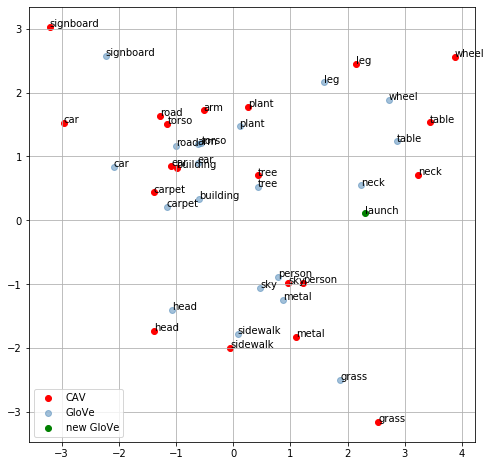

In [382]:
num_concepts = 20
new_glove = 1000 #

plt.figure(figsize=(8,8))
plt.grid()
plt.scatter(Phi1TtoF_Lin[0,:num_concepts], Phi1TtoF_Lin[1,:num_concepts], label = 'CAV', color = 'red')
plt.scatter(Phi2TtoF_Lin[0,:num_concepts], Phi2TtoF_Lin[1,:num_concepts], label = 'GloVe', color = 'steelblue', alpha=0.5)
plt.scatter(Phi2TtoF_Lin[0,n_samples + new_glove], Phi2TtoF_Lin[1,n_samples + new_glove], label = 'new GloVe', color='green')
#plt.xlim([-2.5,2.5])
#plt.ylim([-2.5, 2.5])


plt.legend()

for ii, txt in enumerate(embedding_concepts[:num_concepts]):
    plt.annotate(txt, (Phi1TtoF_Lin[0,ii], Phi1TtoF_Lin[1,ii]))
    plt.annotate(txt, (Phi2TtoF_Lin[0,ii], Phi2TtoF_Lin[1,ii]))

plt.annotate(glove_no_cav_concept_nneigh[new_glove], (Phi2TtoF_Lin[0,n_samples + new_glove], Phi2TtoF_Lin[1,n_samples+new_glove]))

### Validate the manifold alignment

Cosine similarty

In [383]:
counter = 0
for i in range(n_samples):
    cosim = cosine_similarity(Phi2TtoF_Lin.T, Phi1TtoF_Lin.T[i].reshape(-1,8))
    ixs = cosim.argsort(axis=0)[::-1][0:10]
    print('Transformed CAV concept:',embedding_concepts[i])
    print('Closest aligned transformed GloVe concepts:')
    print('-------')
    for j in ixs:
        try:
            print(glove_sorted_concept[j.item()])
        except:
            IndexError
    print('\n')

# print the concepts which do are not closest aligned to their corresponding concept in the other dataset.
#     if embedding_concepts[i] != glove_sorted_concept[ixs[0].item()]:
#         counter +=1
#         print(counter, embedding_concepts[i])

Transformed CAV concept: sky
Closest aligned transformed GloVe concepts:
-------
sky
painted
lobbying
uneven
railway
bovine
monastery
village
cock
isle


Transformed CAV concept: tree
Closest aligned transformed GloVe concepts:
-------
tree
sit
trees
lights
oak
dishwasher
kitchen
landing
deck
horizon


Transformed CAV concept: building
Closest aligned transformed GloVe concepts:
-------
building
kettles
snows
playpen
buses
vehicle
windshields
tour
tombstone
fjords


Transformed CAV concept: person
Closest aligned transformed GloVe concepts:
-------
person
face
skylights
layer
metal
marshy
sacrificial
berries
luxurious
game


Transformed CAV concept: head
Closest aligned transformed GloVe concepts:
-------
head
menagerie
pastime
fronting
retro-futuristic
seas
parking
skylight
vestibule
catwalks


Transformed CAV concept: leg
Closest aligned transformed GloVe concepts:
-------
leg
seat
knives
cocktail
ice
taxiing
guests
pacific
chair
fireplaces


Transformed CAV concept: torso
Closest al

Transformed CAV concept: concrete
Closest aligned transformed GloVe concepts:
-------
concrete
rower
tournament
bass
bully
beached
1-732-390-4697
transplant
cream
springs


Transformed CAV concept: bookcase
Closest aligned transformed GloVe concepts:
-------
bookcase
candle
rugs
showroom
napkin
dump
candles
basement
rhyme
manager


Transformed CAV concept: bedclothes
Closest aligned transformed GloVe concepts:
-------
bedclothes
stocked
undies
passenger
assistant
coaches
relievers
tempera
keypad
freighter


Transformed CAV concept: cow
Closest aligned transformed GloVe concepts:
-------
cow
lighthouse
near
footstool
door
crosswalk
nearby
produce
paths
pancreas


Transformed CAV concept: napkin
Closest aligned transformed GloVe concepts:
-------
napkin
showroom
pantry
shelf
bookcase
semi-trailer
refrigerator
mattress
shelves
rugs


Transformed CAV concept: crosswalk
Closest aligned transformed GloVe concepts:
-------
crosswalk
dugout
workstation
cow
rooftop
alleyway
benches
bedroom
tile

Transformed CAV concept: nursery
Closest aligned transformed GloVe concepts:
-------
nursery
railings
lights
dog
lamp
courtyard
kitchen
cavern
backpack
rear


Transformed CAV concept: decoration
Closest aligned transformed GloVe concepts:
-------
decoration
dunes
bottles
monasteries
velocity
bowling
meal
lagoon
islands
blond


Transformed CAV concept: lobby
Closest aligned transformed GloVe concepts:
-------
lobby
stadium
graveyard
grandstand
pollution
blond
bicentennial
lawn
playground
veranda


Transformed CAV concept: reception
Closest aligned transformed GloVe concepts:
-------
reception
audience
sat
crash
pontoon
drowned
trouser
fountains
plane
airplane


Transformed CAV concept: bar
Closest aligned transformed GloVe concepts:
-------
bar
harbor
mantels
halls
dance
crate
altar
footbridge
circular
doors


Transformed CAV concept: shaft
Closest aligned transformed GloVe concepts:
-------
shaft
freeway
sail
gown
hydrotherapy
matches
steel
urinals
pine
avenue


Transformed CAV concept

Transformed CAV concept: gravestone
Closest aligned transformed GloVe concepts:
-------
sharp
buds
putt
re-elected
countering
curly
unfurnished
tablecloths
sweater
saxophone


Transformed CAV concept: harbor
Closest aligned transformed GloVe concepts:
-------
harbor
crate
oak
pleated
cabin
schoolhouse
altar
storehouse
bar
bulldozer


Transformed CAV concept: restaurant
Closest aligned transformed GloVe concepts:
-------
restaurant
alcove
waterfall
laundry
windowsill
smoking
lid
bells
pots
alleyway


Transformed CAV concept: toyshop
Closest aligned transformed GloVe concepts:
-------
toyshop
convent
bleacher
stained-glass
cheese
motorcycle
baroque
boogie
breakfast
turnstile


Transformed CAV concept: altarpiece
Closest aligned transformed GloVe concepts:
-------
altarpiece
mow
signboards
sphagnum
livestock
annunciation
riff
railway
handbag
closets


Transformed CAV concept: windscreen
Closest aligned transformed GloVe concepts:
-------
windscreen
tear
wings
windshield
wound
canine
outcr

Transformed CAV concept: palace
Closest aligned transformed GloVe concepts:
-------
palace
pol
facility
motocross
hound
convent
mall
statue
gorges
gully


Transformed CAV concept: dolmen
Closest aligned transformed GloVe concepts:
-------
dolmen
slums
peat
iron
motorcyclists
tumulus
farmers
shipyard
linking
divider


Transformed CAV concept: dacha
Closest aligned transformed GloVe concepts:
-------
dacha
drugstore
five-membered
casserole
airlines
buds
ringer
thermostat
tarpaulin
radiation


Transformed CAV concept: embassy
Closest aligned transformed GloVe concepts:
-------
embassy
crashed
production
luncheon
warming
charts
bus
embassies
audience
recipes


Transformed CAV concept: sandbar
Closest aligned transformed GloVe concepts:
-------
sandbar
inscribed
ailerons
quadriplegic
yacht
elongated
elevators
aileron
bleachers
flows


Transformed CAV concept: barbecue
Closest aligned transformed GloVe concepts:
-------
barbecue
advertisement
lawns
ramparts
downtown
clerk
huts
appellate
lung

In [384]:
counter = 0
for i in range(n_samples):
    cosim = cosine_similarity(Phi2TtoF_Lin.T, Phi2TtoF_Lin.T[i].reshape(-1,8))
    ixs = cosim.argsort(axis=0)[::-1][0:10]
    print('Transformed Glove concept:', embedding_concepts[i])
    print('Closest aligned GloVe concepts in common feature space:')
    print('-------')
    for j in ixs:
        try:
            print(glove_sorted_concept[j.item()])
        except:
            IndexError
    print('\n')

Transformed Glove concept: sky
Closest aligned GloVe concepts in common feature space:
-------
sky
lobbying
painted
uneven
bovine
cock
monastery
chapel
marshland
metallic


Transformed Glove concept: tree
Closest aligned GloVe concepts in common feature space:
-------
tree
sit
kitchen
oak
deck
lights
trees
dishwasher
landing
figurine


Transformed Glove concept: building
Closest aligned GloVe concepts in common feature space:
-------
building
kettles
fairground
snows
buses
playpen
tombstone
tour
canine
fjords


Transformed Glove concept: person
Closest aligned GloVe concepts in common feature space:
-------
person
layer
metal
sacrificial
face
marshy
skylights
luxurious
backpacks
berries


Transformed Glove concept: head
Closest aligned GloVe concepts in common feature space:
-------
head
retro-futuristic
parking
fronting
caravans
menagerie
pastime
subsidies
bunk
seas


Transformed Glove concept: leg
Closest aligned GloVe concepts in common feature space:
-------
leg
seat
knives
cocktai

Transformed Glove concept: pillar
Closest aligned GloVe concepts in common feature space:
-------
pillar
rabid
foliage
silk
grills
winding
parachuting
cello
blooms
sash


Transformed Glove concept: bicycle
Closest aligned GloVe concepts in common feature space:
-------
bicycle
grosser
picnic
hound
pond
stairs
dog
elephant
chimney
garden


Transformed Glove concept: stove
Closest aligned GloVe concepts in common feature space:
-------
stove
dangling
bathtub
secluded
dining
tent
chart
sailboat
toilet
forklift


Transformed Glove concept: wing
Closest aligned GloVe concepts in common feature space:
-------
wing
framed
hogan
mad
jail
par-5
lion
stadium
pottery
jaw


Transformed Glove concept: roof
Closest aligned GloVe concepts in common feature space:
-------
roof
swept
ceramic
rooftop
campground
playground
hardwood
campsite
towel
figurines


Transformed Glove concept: bench
Closest aligned GloVe concepts in common feature space:
-------
bench
bags
parks
camper
cottages
white
net
house
pl

Transformed Glove concept: case
Closest aligned GloVe concepts in common feature space:
-------
case
second
first
producing
armchairs
thick
shallow
next
eateries
deep-water


Transformed Glove concept: magazine
Closest aligned GloVe concepts in common feature space:
-------
magazine
charted
controlled
quarter
sandstone
magazines
blouse
nunnery
weeds
tissues


Transformed Glove concept: platform
Closest aligned GloVe concepts in common feature space:
-------
platform
off
platforms
grandstands
elk
leather
producing
darkened
earth
stoneware


Transformed Glove concept: laptop
Closest aligned GloVe concepts in common feature space:
-------
laptop
statue
motorcade
kerosene
bunker
waterfalls
motorbike
ovens
furnace
burner


Transformed Glove concept: fruit
Closest aligned GloVe concepts in common feature space:
-------
fruit
grass
party
crossing
mountain
hallways
pleated
horse
drainage
dirt


Transformed Glove concept: candle
Closest aligned GloVe concepts in common feature space:
-------
ca

Transformed Glove concept: shaft
Closest aligned GloVe concepts in common feature space:
-------
shaft
freeway
gown
sail
hydrotherapy
pine
matches
urinals
steel
avenue


Transformed Glove concept: court
Closest aligned GloVe concepts in common feature space:
-------
court
rocks
missions
grandstand
weather
orchid
coral
dresses
renovated
eyes


Transformed Glove concept: roundabout
Closest aligned GloVe concepts in common feature space:
-------
roundabout
elephants
forest
furnace
disposal
bedrooms
bingo
garden
mall
pickup


Transformed Glove concept: lake
Closest aligned GloVe concepts in common feature space:
-------
lake
shores
cups
flooded
bathhouse
wings
gore
photograph
finals
biography


Transformed Glove concept: barrel
Closest aligned GloVe concepts in common feature space:
-------
barrel
diplomatic
chalet
theater
tarmac
boulder
jet
mine
takeoff
undertaken


Transformed Glove concept: ship
Closest aligned GloVe concepts in common feature space:
-------
ship
jurors
planetary
drough

Transformed Glove concept: driveway
Closest aligned GloVe concepts in common feature space:
-------
driveway
grandstand
pollution
orchid
fashion
pigs
toilets
cottage
gazebo
front


Transformed Glove concept: fairway
Closest aligned GloVe concepts in common feature space:
-------
fairway
cats
cock
wharf
carpeting
corridors
breakwater
grass
valley
bar


Transformed Glove concept: courthouse
Closest aligned GloVe concepts in common feature space:
-------
courthouse
wine
cable-stayed
recorders
sand
tunnel
obelisk
knee
wire
creek


Transformed Glove concept: yard
Closest aligned GloVe concepts in common feature space:
-------
yard
planter
breakwater
right
movie
bowls
ruined
flat-top
turret
dog


Transformed Glove concept: carousel
Closest aligned GloVe concepts in common feature space:
-------
carousel
flight
stainless
cake
deck
pedestal
landing
guests
kitchen
10-by-10-foot


Transformed Glove concept: slide
Closest aligned GloVe concepts in common feature space:
-------
slide
plane
constru

Transformed Glove concept: barbecue
Closest aligned GloVe concepts in common feature space:
-------
barbecue
lawns
ramparts
advertisement
downtown
balustrade
winding
dolmens
vents
fairyland


Transformed Glove concept: dam
Closest aligned GloVe concepts in common feature space:
-------
dam
beach
bridge
watercolor
cactus
cherry
mansion
coconut
riverbed
concrete


Transformed Glove concept: fence
Closest aligned GloVe concepts in common feature space:
-------
fence
ocean
landowner
football
courthouse
sand
3-wood
gear
chair
thoroughfare


Transformed Glove concept: excavation
Closest aligned GloVe concepts in common feature space:
-------
excavation
threaten
ruins
recorder
headlight
palms
pump
fermenter
diamond
ranch


Transformed Glove concept: flood
Closest aligned GloVe concepts in common feature space:
-------
flood
axle
pelvis
aqueducts
flames
upstate
crew
ballroom
midtown
pacific


Transformed Glove concept: crevasse
Closest aligned GloVe concepts in common feature space:
-------
cr

## Explore new concepts related to scenicness